### Tarea 2 - Aprendizaje automático

En este cuaderno se desarrollarán los siguientes puntos:

- Construya la arquitectura de una red neuronal Autoencoder en PyTorch
- Escriba el training loop teniendo en cuenta la técnica de Gradient Accumulation. 
- Adapte esos puntos para funcionar con imágenes. Para esto debe investigar Vision Transformers, y explicar la diferencia con redes convolucionales e implementar (pueden usar las capas pre-existentes de PyTorch).
- Escoja un dataset tabular, y usar las técnicas aprendidas de clustering (k-means y DB-Scan), investigar y hacer una implementación desde cero de BFR, y comparar el resultado de los tres.

In [1]:
# Importe de libreras necesarias

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


C:\Users\jmuri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Se realizara la arquitectura del autoencoder lineal y convolucional, pero solo se utilizará  el modelo convolucional para efectos de comparación con Vision Transformers (ViT).

In [ ]:
# Arquitectura del Autoencoder Lineal 

class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super(Autoencoder_Linear, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()  # Output entre 0 y 1 si los datos están normalizados
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [2]:
#Arquitectura del Autoencoder Convolucional

class Autoencoder_Convolutional(nn.Module):
    def __init__(self):
        super().__init__()   

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) 
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid() # Output entre 0 y 1 si los datos están normalizados
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
# Función para graficar las reconstrucciones

def plot_reconstructions(inputs, outputs, epoch, N=8):
    inputs = inputs[:N]
    outputs = outputs[:N].view(-1, 1, 28, 28)

    fig, axes = plt.subplots(2, N, figsize=(N * 0.8, 1.5))
    fig.suptitle(f"Reconstrucciones en época {epoch}", fontsize=14)
    
    for i in range(N):
        axes[0, i].imshow(inputs[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].detach().squeeze(), cmap='gray')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
# Preprocesamiento y datos

# Transformaciones 
transform = transforms.ToTensor()

# Cargar el dataset MNIST
full_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # 60,000 imágenes
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Dividir el dataset en entrenamiento y validación
# Definir tamaños de entrenamiento y validación
train_size = int(0.8 * len(full_train_dataset))   # 80% para entrenamiento (48,000)
val_size = len(full_train_dataset) - train_size   # 20% para validación (12,000)

# Dividir el dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch [1/10], Train Loss: 0.0841, Val Loss: 0.0504
Epoch [2/10], Train Loss: 0.0295, Val Loss: 0.0182


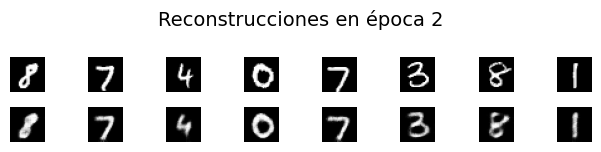

Epoch [3/10], Train Loss: 0.0145, Val Loss: 0.0119
Epoch [4/10], Train Loss: 0.0104, Val Loss: 0.0093


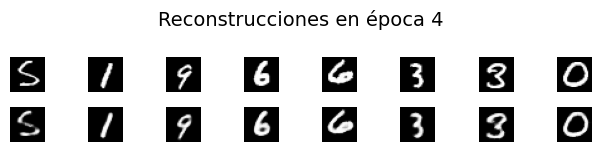

Epoch [5/10], Train Loss: 0.0085, Val Loss: 0.0078
Epoch [6/10], Train Loss: 0.0073, Val Loss: 0.0069


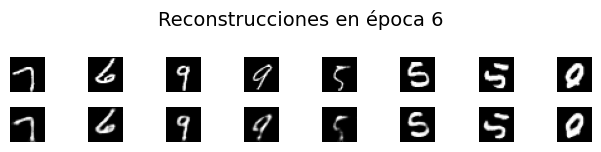

Epoch [7/10], Train Loss: 0.0065, Val Loss: 0.0063
Epoch [8/10], Train Loss: 0.0059, Val Loss: 0.0057


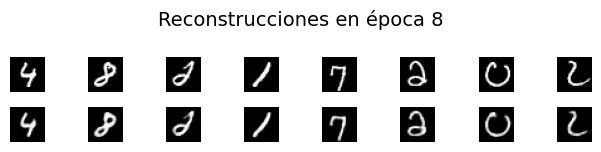

Epoch [9/10], Train Loss: 0.0054, Val Loss: 0.0053
Epoch [10/10], Train Loss: 0.0050, Val Loss: 0.0048


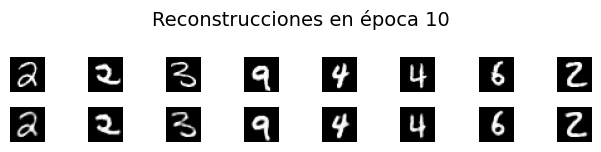

In [5]:
# Modelo, optimizador y función de pérdida

model_c = Autoencoder_Convolutional()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_c.parameters(), lr=1e-3, weight_decay=1e-5)

# Hiperparámetros de Graddient Accumulation

accumulation_steps = 4  
num_epochs = 10


# Training loop

model_c.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (inputs, _) in enumerate(train_loader):
        outputs = model_c(inputs)
        loss = criterion(outputs, inputs)
        loss = loss / accumulation_steps  
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps  # Deshacer la división

    avg_train_loss = running_loss / len(train_loader)

    # Validación

    model_c.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, _ in val_loader:
            val_outputs = model_c(val_inputs)
            loss = criterion(val_outputs, val_inputs)
            val_loss += loss.item() * val_inputs.size(0)
            
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Graficar cada 2 épocas

    if (epoch + 1) % 2 == 0:
        with torch.no_grad():
            sample, _ = next(iter(train_loader))
            reconstructed = model_c(sample)
            plot_reconstructions(sample, reconstructed, epoch+1)
            
    model_c.train()


In [6]:
# Guardar el modelo entrenado

torch.save(model_c.state_dict(), "autoencoder_convolucional.pth")

Pérdida promedio en TEST: 0.0046


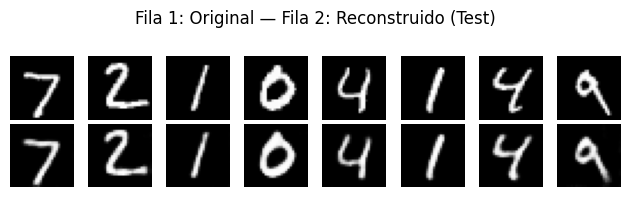

In [7]:
# Cargar el modelo entrenado
model_c = Autoencoder_Convolutional()                
model_c.load_state_dict(torch.load("autoencoder_convolucional.pth"))           
model_c.eval()                                        

# Evaluación cuantitativa en el set de test
test_loss = 0.0
with torch.no_grad():
    for imgs, _ in test_loader:                        
        outputs = model_c(imgs)
        loss = criterion(outputs, imgs)
        test_loss += loss.item() * imgs.size(0)

avg_test_loss = test_loss / len(test_loader.dataset)
print(f"Pérdida promedio en TEST: {avg_test_loss:.4f}")

# Visualización cualitativa 
N = 8
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))           # lote de prueba
    recons = model_c(sample_imgs)[:N]

# Mostrar reconstrucciones
fig, axes = plt.subplots(2, N, figsize=(N*0.8, 2.0))
fig.suptitle("Fila 1: Original — Fila 2: Reconstruido (Test)", fontsize=12)

for i in range(N):
    axes[0, i].imshow(sample_imgs[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recons[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


Tras completar el entrenamiento del autoencoder convolucional y realizar la evaluación sobre el conjunto de prueba (test set), se observa que el modelo logró una excelente capacidad de generalización. La pérdida promedio en el test fue del 0.0046, es decir, fue muy baja, lo que indica que el modelo es capaz de reconstruir imágenes nunca vistas durante el entrenamiento con alta fidelidad.

Además, la inspección visual de los resultados mostró que las reconstrucciones conservan de manera clara la forma, trazo y estructura de los dígitos originales, incluso en ejemplos difíciles. Esto sugiere que el modelo ha aprendido representaciones latentes significativas y robustas, capturando los patrones del conjunto MNIST.

En conjunto, tanto las métricas cuantitativas como la evaluación cualitativa respaldan que el modelo tuvo un desempeño sobresaliente.